# Setting up a Graph Database for the US Government IT Portfolios

In [2]:
import pandas as pd
import numpy as np
import dabl
%matplotlib inline
import os
from dabl import plot
import matplotlib.pyplot as plt
import datetime as dt
import dtale

In [3]:
directory = '/Users/lawrence/Documents/GitHub/data_files_for_access/ProjectHack3data_Challenge9_from_Said_school/2013/'

# Bring in Projects file

In [20]:
Projects=pd.read_csv(directory+'Projects.csv', encoding= 'unicode_escape')

In [21]:
d = dtale.show(Projects, ignore_duplicate=True)

In [22]:
d

In [23]:
d.kill()

Executing shutdown...


2020-08-18 15:47:48,908 - INFO     - Executing shutdown...


In [5]:
Projects=Projects.drop(['Agency Project ID','Project Description','Lifecycle Cost', 'Cost Variance (%)','Projected/Actual Cost ($ M)','Updated Time','Unique Project ID'],axis=1)

In [6]:
Projects['Completion Date (B1)']=Projects['Completion Date (B1)'].astype('datetime64')
Projects['Planned Project Completion Date (B2)']=Projects['Planned Project Completion Date (B2)'].astype('datetime64')
Projects['Start Date']=Projects['Start Date'].astype('datetime64')
Projects['Projected/Actual Project Completion Date (B2)']=Projects['Projected/Actual Project Completion Date (B2)'].astype('datetime64')
Projects['Updated Date']=Projects['Updated Date'].astype('datetime64')
Projects['Business Case ID']=Projects['Business Case ID'].astype('category')
Projects['Agency Code']=Projects['Agency Code'].astype('category')
Projects['Project ID']=Projects['Project ID'].astype('category')

In nearly all cases, Completion Date (B1) > Planned Project Completion Date (B2)

In some cases 'Projected/Actual Project Completion Date (B2) < Planned Project Completion Date (B2)
But in most cases, it is the other way around , so that Planned < Project /Actual i,e is earlier

And in most cases, where not equal: Projected/Actual Project Completion Date (B2)' <   'Completion Date (B1)'

therefore, Planning progresses in this order 

1. Planned Project Completion Date (B2)
2. Projected/Actual Project Completion Date (B2)
3. Completion Date (B1) 

So I will create:

- Planned Duration
 - Project Delay, which is the worst Project Delay I can find
Schedule variance appears to be Planned Project Completion Date (B2) MINUS 'Projected/Actual Project Completion Date (B2)
and Hence is often listed as Negative.
Which is okay, so Negative just means that Progress was underwhelming as normal.
So I can drop schedule variance and schedule  variance % because we have calculated it better as Project_Delay

In [7]:
# worked this out by a variety of boolean mixing such as:
# constraint=(Projects['Projected/Actual Project Completion Date (B2)']<Projects['Completion Date (B1)'])&(pd.notna(Projects['Projected/Actual Project Completion Date (B2)']))&(pd.notna(Projects['Completion Date (B1)']))
# Projects [constraint]

Projected/Actual more or less the same as Planned cost.
- sometimes a little more which makes sense
- a few with 0s which is okay
- so maybe best to drop 'Projected/Actual'

Lifecycle cost is:
- often zero
- mostly identical to Planned
- so best to drop this too. 
Looks like mostly Cost Variance +Planned Cost = Project/Actual Cost
i.e. just keep Planned cost and Cost Variance

In [8]:
# worked this out from variants of: 
# plt.scatter ((Projects['Planned Cost ($ M)'],Projects['Cost Variance ($ M)']))

In [9]:
Projects['Planned_Duration']=(Projects['Planned Project Completion Date (B2)']-Projects['Start Date']).dt.days
Projects['Project_delay']=(np.maximum(Projects['Projected/Actual Project Completion Date (B2)']-Projects['Planned Project Completion Date (B2)'],Projects['Completion Date (B1)']-Projects['Planned Project Completion Date (B2)'])).dt.days

In [10]:
Projects=Projects.drop(['Planned Project Completion Date (B2)','Completion Date (B1)','Projected/Actual Project Completion Date (B2)'],axis=1)

In [11]:
Projects['Start_days_after_2000']=(Projects['Start Date']-pd.Timestamp('2000-01-01')).dt.days

In [12]:
Projects=Projects.drop(['Schedule Variance (%)','Schedule Variance (in days)'],axis=1)

In [13]:
Projects['Updated Date']=(Projects['Updated Date']-Projects['Start Date']).dt.days # where this is now the no of days the update happened after start date

In [16]:
Projects=Projects.dropna()

In [19]:
Projects

,Unique Investment Identifier,Business Case ID,Agency Code,Agency Name,Investment Title,Project ID,Project Name,Start Date,Cost Variance ($ M),Planned Cost ($ M),Updated Date,Planned_Duration,Project_delay,Start_days_after_2000
1,005-000001723,212,5,Department of Agriculture,AMS Infrastructure WAN and DMZ (AMSWAN),657,Virtualization,2011-10-01,0.000000,0.179000,60,182.0,0.0,4291
3,005-000001822,213,5,Department of Agriculture,APHIS Electronic Permits System (ePermits),661,ePermits O&M FY11 Part 1.,2011-04-01,0.364100,1.820500,426,182.0,0.0,4108
4,005-000001822,213,5,Department of Agriculture,APHIS Electronic Permits System (ePermits),662,ePermits O&M FY12 Part 1,2012-04-01,0.000000,1.713000,60,182.0,0.0,4474
6,005-000001822,213,5,Department of Agriculture,APHIS Electronic Permits System (ePermits),664,BRS Field Reports Phase 2,2010-12-31,0.000000,0.010000,265,90.0,0.0,4017
7,005-000000038,214,5,Department of Agriculture,APHIS Enterprise Infrastructure,665,Enterprise Management,2010-10-01,0.000000,46.960000,356,364.0,0.0,3926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,016-000002145,1054,16,Social Security Administration,Earnings Redesign,1053,Non-DCS Support,2011-10-03,0.000003,0.203546,207,363.0,0.0,4293
2463,016-000002253,1056,16,Social Security Administration,National Support Center (Non-Major Infrastruct...,1035,FY11 -NSC,2011-06-01,-0.013272,5.610005,152,121.0,0.0,4169
2464,016-000002253,1056,16,Social Security Administration,National Support Center (Non-Major Infrastruct...,1036,FY12 - NSC Transition Planning,2011-10-01,0.117155,0.982165,328,365.0,0.0,4291
2466,016-000002253,1056,16,Social Security Administration,National Support Center (Non-Major Infrastruct...,1039,FY12 - MGMT O/H,2011-10-01,-0.000001,0.159365,212,365.0,0.0,4291


In [18]:
d = dtale.show(Projects, ignore_duplicate=True)

AttributeError: 'int' object has no attribute 'strip'

## Work out Data Structure as you go. 
Agency >> Investment (w Business Case ) >> Project ( Start, Completion, Cost, Variances)

## Create a basic example in Neo4j inline

CREATE (m:Agency {name:'Dept Agriculture',Code:5})
CREATE (n:Investment {name:'AMS Infrastructure WAN and DMZ (AMSWAN)', Identifier:'005-000001723'})
CREATE (o:Project {name:'Virtualization', Id:657,Cost_Variance:0,Planned_Cost:0.179,Updated_Date:60,Planned_Duration:182, Project_delay:0,Start_days_after_2000:4291})
CREATE (m)-[:invests]->(n)
CREATE (n)-[:pays_for]->(o)

After testing this, I can bring in CSV: see further below

## Data exploration

In [14]:
constraint=Projects['Updated Date']>Projects['Planned_Duration'] #find only those rows where Update date is after Project is meant to have finished

In [15]:
Projects_Training=Projects[constraint]

In [16]:
Stripped_for_delay_forecast=Projects_Training.drop(['Cost Variance ($ M)','Unique Investment Identifier','Business Case ID','Agency Name','Investment Title','Project ID','Project Name','Start Date'],axis=1)

/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/supervised.py:528: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  FutureWarning)


Target looks like regression


/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 4 outliers in column Updated Date.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 6 outliers in column Planned_Duration.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 4 outliers in column Start_days_after_2000.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 3 outliers in column Planned Cost ($ M).
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]


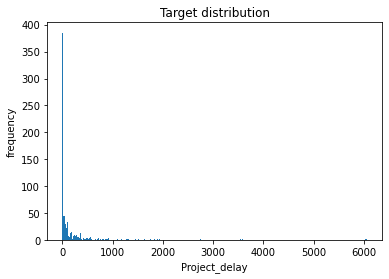

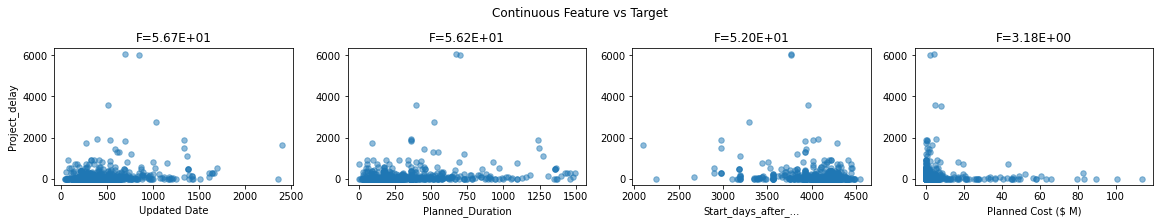

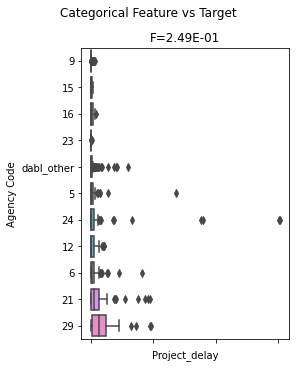

In [17]:
dabl.plot(Stripped_for_delay_forecast,'Project_delay')

In [18]:
Stripped_for_cost_forecast=Projects_Training.drop(['Project_delay','Unique Investment Identifier','Business Case ID','Agency Name','Investment Title','Project ID','Project Name','Start Date'],axis=1)

/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/supervised.py:528: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  FutureWarning)


Target looks like regression


/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 3 outliers in column Planned Cost ($ M).
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 6 outliers in column Planned_Duration.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 4 outliers in column Updated Date.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:621: UserWarning: Dropped 4 outliers in column Start_days_after_2000.
  int(dropped), series.name), UserWarning)
/Users/lawrence/DABL_Env/lib/python3.7/site-packages/dabl/plot/utils.py:364: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]


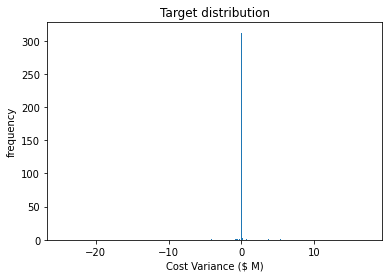

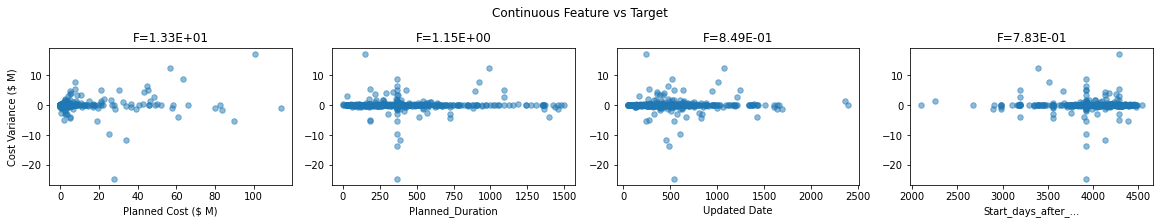

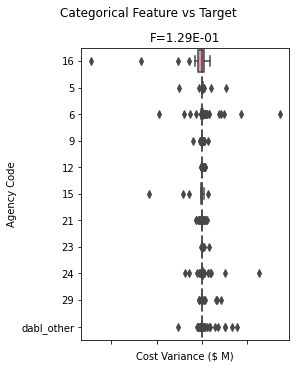

In [19]:
dabl.plot(Stripped_for_cost_forecast,'Cost Variance ($ M)')

In [20]:
# Could do a similar strip down for forecasting delay

In [21]:
# did not bother with a DABL clean

In [22]:
# Not bothering w classiifcation model for now

## Train a regression

In [23]:
Delay_regression_model=dabl.SimpleRegressor(random_state=0)

In [24]:
X=Projects_Training.drop(['Project_delay','Cost Variance ($ M)','Unique Investment Identifier','Business Case ID','Agency Name','Investment Title','Project ID','Project Name','Start Date'],axis=1)

In [25]:
y=Projects_Training['Project_delay']

In [26]:
Delay_regression_model.fit(X,y)

Running DummyRegressor()
r2: -0.009 neg_mean_squared_error: -215755.852
=== new best DummyRegressor() (using r2):
r2: -0.009 neg_mean_squared_error: -215755.852

Running DecisionTreeRegressor(max_depth=1)
r2: -0.086 neg_mean_squared_error: -226917.448
Running DecisionTreeRegressor(max_depth=5)
r2: -0.425 neg_mean_squared_error: -276607.244
Running Ridge(alpha=10)
r2: 0.050 neg_mean_squared_error: -205111.219
=== new best Ridge(alpha=10) (using r2):
r2: 0.050 neg_mean_squared_error: -205111.219

Running Lasso(alpha=10)
r2: 0.058 neg_mean_squared_error: -205306.111
=== new best Lasso(alpha=10) (using r2):
r2: 0.058 neg_mean_squared_error: -205306.111


Best model:
Lasso(alpha=10)
Best Scores:
r2: 0.058 neg_mean_squared_error: -205306.111


SimpleRegressor(random_state=0)

In [27]:
# not bothered w Cost regression because would get just as rubbish results

## Export to CSV en route to Neo4j

In [28]:
Projects=Projects.rename(columns={"Agency Name": "Agency_Name", "Agency Code":"Agency_Code",'Investment Title':'Investment_Title','Unique Investment Identifier':'Unique_Investment_Identifier','Project Name':'Project_Name','Project ID':'Project_ID','Start Date':'Start_Date', 'Cost Variance ($ M)':'Cost_Variance','Planned Cost ($ M)':'PlannedCost','Updated Date':'Updated_Date','Business Case ID':'Business_Case_ID'})  

In [29]:
Projects.to_csv(directory+'Oxford_Projects_Out.csv', index=False)

#Cypher code for Neo4j
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Projects_Out.csv' AS row
MERGE (m:Agency {name:row.Agency_Name,Code:row.Agency_Code})
MERGE (n:Investment {name:row.Investment_Title,Identifier:row.Unique_Investment_Identifier,Business_Case:row.Business_Case_ID})
MERGE (o:Project {name:row.Project_Name,Id:row.Project_ID,Cost_Variance:toFloat(row.Cost_Variance),Planned_Cost:toFloat(row.PlannedCost),Updated_Date:toInteger(row.Updated_Date),Planned_Duration:toInteger(row.Planned_Duration),Project_delay:toInteger(row.Project_delay),Start_days_after_2000:toInteger(row.Start_days_after_2000)})
MERGE (m)-[:invests]->(n)
MERGE (n)-[:pays_for]->(o)

# Pull in strategic investment information

In [31]:
Strategy=pd.read_csv(directory+'Exhibit300A.csv', encoding= 'unicode_escape')

In [32]:
Strategy=Strategy.drop(['Investment Title (Exhibit 53)','Investment Title (Exhibit 300)','Date of Last Change to Activities','Date of Last Update to Activities','Date of Last Update to Activities','Date of Last Update to Activities','Date of Last Change to Contracts','Date of Last Change to Performance Metrics','Date of Last Tech Stat','Budget Year','Date of Last Investment Detail Update','Investment Auto Submission Date'],axis=1)

In [33]:
Strategy=Strategy.drop(['Data Freshness','Date of Last Change to CIO Evaluation','Date of Last Update to CIO Evaluation'],axis=1)

In [34]:
Strategy=Strategy.drop(['IPT Charter Date','Date Investment First Submitted'],axis=1)

In [35]:
Strategy=Strategy.drop(['Business Case ID'],axis=1)

In [36]:
Strategy=Strategy.drop(['CIO Evaluation Color'],axis=1)

In [37]:
Strategy['Date of Last Baseline']=Strategy['Date of Last Baseline'].astype('datetime64')

In [38]:
Strategy=Strategy.dropna()

In [39]:
Strategy=Strategy.rename(columns={'Agency Name':'Agency_Name',"Bureau Name": "Bureau_Name",'Bureau Code':'Bureau_Code','Number of changes to Baseline':'Number_of_changes_to_Baseline','Evaluation (by Agency CIO)':'Evalu)ation_by_CIO"}'})

In [40]:
Strategy=Strategy.rename(columns={'Evalu)ation_by_CIO"}':'Evaluation_by_CIO','Date of Last Baseline':'Date_Last_Baseline'})

## Run  a classification to predict how CIO rates investments

In [41]:
Stripped_for_CIO_forecast=Strategy.drop(['Bureau_Name','Brief Summary','Summary of Performance Gap','Accomplishments PY','Accomplishments CY BY','Explanation of Change to PY or CY Funding','No EVM Explanation','CIO Evaluation Comments'],axis=1)

In [ ]:
dabl.plot(Stripped_for_CIO_forecast,'Evaluation_by_CIO')

In [ ]:
Investment_classification_model=dabl.SimpleClassifier (random_state=0)

In [ ]:
X=Strategy.drop(['Evaluation_by_CIO','Bureau_Name','Brief Summary','Summary of Performance Gap','Accomplishments PY','Accomplishments CY BY','Explanation of Change to PY or CY Funding','No EVM Explanation','CIO Evaluation Comments'],axis=1)

In [ ]:
y=Strategy["Evaluation_by_CIO"]

In [ ]:
Investment_classification_model.fit(X,y)

In [ ]:
Contracts

## Work out Data Structure as you go. 
## This results in the following Cypher code to be placed into Neo4j
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Strategy_Out.csv' AS row 
MERGE (m:Agency {Code:row.Agency_Code})
MERGE (o:Bureau {Code:row.Bureau_Code,Name:row.Bureau_Name})
MERGE (n:Investment {Identifier:row.Unique_Investment_Identifier})
CREATE (m)-[:owns]->(o)
CREATE (o)-[:responsible_for]->(n)
SET n.Summary=row.Brief_Summary
SET n.Performance_Gap=row.Summary_of_Performance_Gap
SET n.Evaluation_by_CIO=row.Evaluation_by_CIO
SET n.Changes_to_Baseline=row.Number_of_changes_to_Baseline
SET n.Last_Baseline=row.Date_Last_Baseline

LOAD CSV WITH HEADERS FROM 'file:///Oxford_Strategy_Out.csv' AS row 
MATCH (m:Agency {Code:row.Agency_Code})
SET m.name = row.Agency_Name
RETURN m

"MERGE matches on the entire pattern you specify within a single clause...The solution is to MERGE on the unique property and then use SET to update additional properties.

In [ ]:
Strategy=Strategy.rename(columns={'Unique Investment Identifier':'Unique_Investment_Identifier','Brief Summary':'Brief_Summary',
'Summary of Performance Gap':'Summary_of_Performance_Gap','Agency Code':'Agency_Code'})

In [ ]:
Strategy.to_csv(directory+'Oxford_Strategy_Out.csv', index=False)

# Bring in Contracts file

In [ ]:
Contracts=pd.read_csv(directory+'Contracts.csv', encoding= 'unicode_escape')

In [ ]:
Contracts=Contracts.drop(['Business Case ID','Agency Code','Agency Name','Investment Title','Agency Contract ID','Contract Status','Contracting Agency ID','Contract Number (PIID)','Performance Based Contract (USAspending)','Contract Start Date (USAspending)','Contract End Date (USAspending)','Contract Compete (USAspending)','Base Contract ID (USAspending)'
        ,'Identifying Agency ID (USAspending)','Transaction Number (USAspending)','Timestamp (Base Contract)'],axis=1)

In [ ]:
Contracts=Contracts.drop(['IDV Agency ID','Match found in USAspending','Solicitation ID (USAspending)'],axis=1)

In [ ]:
Contracts=Contracts.rename(columns={'Unique Investment Identifier':'Unique_Investment_Identifier','Contract ID':'Contract_ID','IDV PIID':'IDV_PIID','Vendor Name (USAspending)':'Vendor_name','Action Obligation Amount (In $ million) (USAspending)':'Contract_size','Contract Description (USAspending)':'Contract_Description'})

## Start of training a model with data across two dataframes:
**Do Suppliers predict CIO Evaluation success?**
**Work in progress**

In [ ]:
Contracts1=Contracts.drop(['Contract_ID','Contract_size','Contract_Description','Type of Contract (USAspending)','Timestamp (Contract)'],axis=1)

In [ ]:
# Use merge or join to add CIO Evaluation in from Strategy DF, matching w Unique Investment Identifier. Then fit

## Work out Data Structure as you go. 
## This results in the following Cypher code to be placed into Neo4j

In [ ]:
Contracts=Contracts.dropna()

In [ ]:
Contracts

In [ ]:
Contracts.to_csv(directory+'Oxford_Contracts_Out.csv', index=False)

In [ ]:
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Contracts_Out.csv' AS row 
MERGE (m:Contract {ID:row.Contract_ID})
MERGE (n:Investment {Identifier:row.Unique_Investment_Identifier})
MERGE (o:Supplier {ID:row.IDV_PIID})
SET m.Description=row.Contract_Description
SET m.Contract_size=row.Contract_size
SET o.name=row.Vendor_name
CREATE (n)-[:lets_contract]->(m)
CREATE (n)-[:uses_Supplier]->(o)
CREATE (o)-[:delivers]->(m)


# Bring in Metrics file

In [ ]:
Metrics=pd.read_csv(directory+'Performance_Metrics.csv', encoding= 'unicode_escape')

In [ ]:
Metrics=Metrics.drop(['Business Case ID','Agency Name','Agency Performance Metric ID','Comment','Updated Date','Updated Time','Reporting Frequency'],axis=1)

In [ ]:
Metrics=Metrics.drop(['Target for PY','Actual for PY','Most Recent Actual Results','Measurement Condition'],axis=1)

In [ ]:
Metrics=Metrics.rename(columns={'Unique Investment Identifier':'Unique_Investment_Identifier','Performance Metric ID':'Performance_Metric_ID','Metric Description':'Metric_Description','Unit of Measure':'Unit_of_Measure','FEA Performance Measurement Category Mapping':'Measurement_category','Actuals have Met/Not Met Target':'Metric_results'})

In [ ]:
Metrics=Metrics.dropna()

In [ ]:
Metrics['Agency Code']=Metrics['Agency Code'].astype('category')

In [ ]:
Metrics

## Run  a classification to see if one can predict KPI success

In [ ]:
Stripped_for_KPI_forecast=Metrics.drop(['Performance_Metric_ID','Investment Title','Baseline','Target for CY'],axis=1)

In [ ]:
dabl.plot(Stripped_for_KPI_forecast,'Metric_results')

In [ ]:
Metric_classification_model=dabl.SimpleClassifier (random_state=0)

In [ ]:
X=Metrics.drop(['Performance_Metric_ID','Investment Title','Baseline','Target for CY','Metric_results'],axis=1)

In [ ]:
y=Metrics['Metric_results']

In [ ]:
Metric_classification_model.fit(X,y)

In [ ]:
Metrics.to_csv(directory+'Oxford_Metrics_Out.csv', index=False)

from this, we know that Metric ID is unique
constraint=(Metrics.duplicated(subset='Performance_Metric_ID', keep=False))==True
Metrics[constraint]

## Work out Data Structure as you go. 
## This results in the following Cypher code to be placed into Neo4j
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Metrics_Out.csv' AS row 
MERGE (m:Metric {ID:row.Performance_Metric_ID})
MERGE (n:Investment {Identifier:row.Unique_Investment_Identifier})
SET m.Description=row.Metric_Description
SET m.Measurement_category=row.Measurement_category
SET m.Metric_results=row.Metric_results
MERGE (n)-[:judged_by]->(m)

# Bring in Business Mapping

In [ ]:
Mapping=pd.read_csv(directory+'Exhibit53.csv', encoding= 'unicode_escape')

In [ ]:
Mapping=Mapping.drop(['Agency Code','Agency Name','Previous UPI','Investment Category','Bureau Code','Bureau Name','Part of Exhibit 53'],axis=1)

In [ ]:
Mapping=Mapping.drop(['Mission Delivery And Management Support Area','Line Item Descriptor','Investment Title','Investment Description','Updated Date'],axis=1)

In [ ]:
Mapping=Mapping.drop(['Budget Year','XML Request ID','Updated Time','O&M BY Contributions ($ M)','O&M BY Agency Funding ($ M)','O&M CY Contributions ($ M)'],axis=1)

In [ ]:
Mapping=Mapping.drop(['O&M CY Agency Funding ($ M)','O&M PY Contributions ($ M)','O&M PY Agency Funding ($ M)','DME BY Contributions ($ M)'],axis=1)

In [ ]:
Mapping=Mapping.drop(['Segment Architecture - Agency Segment','Total IT Spending FY2011 (PY) ($ M)','Total IT Spending FY2012 (CY) ($ M)'],axis=1)

In [ ]:
Mapping=Mapping.drop(['DME PY Contributions ($ M)','DME CY Contributions ($ M)','DME BY Agency Funding ($ M)'],axis=1)

In [ ]:
Mapping=Mapping.rename(columns={'Unique Investment Identifier':'Unique_Investment_Identifier','Type of Investment':'Investment_type'})

In [ ]:
Mapping=Mapping.rename(columns={'FEA BRM Mapping - Sub-Function':'Sub-Function','FEA BRM Mapping - Primary Function':'Function','FEA BRM Mapping - Business Area':'Business_Area'})

In [ ]:
Mapping=Mapping.rename(columns={'Service Code Mapping - Component':'Service_Component','Service Code Mapping - Primary Function':'Service','Function':'Business Function'})

In [ ]:
Mapping=Mapping.rename(columns={'Service Code Mapping - Business Area':'Service Area','Segment Architecture - Federal Standard Segment':'Architecture_code'})

In [ ]:
Mapping=Mapping.drop(['Total IT Spending FY2013 (BY) ($ M)','DME PY Agency Funding ($ M)'],axis=1)

In [ ]:
Mapping=Mapping.rename(columns={'DME CY Agency Funding ($ M)':'Enhancement_spend_$m'})

In [ ]:
Mapping=Mapping.rename(columns={'Enhancement_spend_$M)':'Enhancement_spend_$m'})

In [ ]:
Mapping=Mapping.rename(columns={'Service Area':'Service_Area'})

In [ ]:
Mapping=Mapping.rename(columns={'Business Function':'Business_Function'})

In [ ]:
Mapping=Mapping.dropna()

In [ ]:
Mapping.to_csv(directory+'Oxford_Mapping_Out.csv', index=False)

## Code for Neo4j
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Mapping_Out.csv' AS row 
MERGE (n:Investment {Identifier:row.Unique_Investment_Identifier})
SET n.Enhancement_spend_$m=toFloat(row.Enhancement_spend_$m)
MERGE (o:Service {name:row.Service})
MERGE (p:Business_Area {name:row.Business_Area})
MERGE (q:Business_Function {name:row.Business_Function})
SET n.Investment_type=row.Investment_type
MERGE (n)-[:has_business_function]->(q)
MERGE (q)-[:serves]->(p)
MERGE (n)-[:is_a_type_of]->(o)

# Bring in activities

In [172]:
Activities=pd.read_csv(directory+'Activities.csv', encoding= 'unicode_escape')

In [173]:
Activities=Activities.drop(['Agency Name','Business Case ID','Investment Title','Date of Last Change','Baseline ID'],axis=1)

In [174]:
Activities=Activities.drop(['Cost Variance','Cost Variance Percent'],axis=1)

In [175]:
# Cost Variance and Cost % are unreliable: they give different signs, so dropped

In [176]:
Activities=Activities.drop(['Structure ID','Schedule Variance (in days)','Schedule Variance Percent','Schedule Duration (in days)'],axis=1)

In [177]:
Activities=Activities.dropna(subset=['Unique Investment Identifier','Agency Code','Agency Activity ID','Project ID','Activity Name','Start Date Planned','Completion Date Planned',
                                     'Total Costs Planned','Activity Status','Has No Child Activity','Date of Last Update','Unique Activity ID'])

In [178]:
Activities=Activities.drop(['Agency Activity ID'],axis=1)

In [179]:
Activities['Start Date Planned'] = pd.to_datetime(Activities['Start Date Planned'])
Activities['Start Date Projected'] = pd.to_datetime(Activities['Start Date Projected'])
Activities['Start Date Actual'] = pd.to_datetime(Activities['Start Date Actual'])
Activities['Completion Date Planned'] = pd.to_datetime(Activities['Completion Date Planned'])
Activities['Completion Date Projected'] = pd.to_datetime(Activities['Completion Date Projected'])
Activities['Completion Date Actual'] = pd.to_datetime(Activities['Completion Date Actual'])

In [180]:
Activities['Planned_Duration']=np.subtract(Activities['Completion Date Planned'],Activities['Start Date Planned'])

In [181]:
Activities=Activities.drop('Completion Date Planned',axis=1)

In [182]:
Activities['Actual_duration']=np.subtract(Activities['Completion Date Actual'],Activities['Start Date Actual'])
Activities['Actual_start_delay']=np.subtract(Activities['Start Date Actual'],Activities['Start Date Planned'])

In [183]:
Activities=Activities.drop(['Start Date Actual','Completion Date Actual'],axis=1)

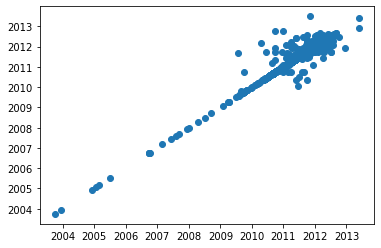

In [184]:
# This shows that a project may well start early or late
plt.scatter (Activities['Start Date Planned'],Activities['Start Date Projected'])

In [185]:
# similar holds for these
# plt.scatter (Activities['Start Date Planned'],Activities['Start Date Actual'])
# plt.scatter (Activities['Start Date Projected'],Activities['Start Date Actual'])

In [186]:
Training_set=Activities[Activities['Activity Status']=='Completed - Closed']
Run_time_set=Activities[Activities['Activity Status']=='In-progress']

In [ ]:
Training_set['Cost_increase_%']=np.divide(np.subtract(Training_set['Total Costs Actual'],Training_set['Total Costs Planned']),Training_set['Total Costs Planned'])
Training_set['Schedule_increase_%']=np.divide(np.subtract(Training_set['Actual_duration'],Training_set['Planned_Duration']),Training_set['Planned_Duration'])

In [188]:
Activities=Activities.drop(['Total Costs Actual'],axis=1)
Training_set=Training_set.drop(['Total Costs Actual'],axis=1)

In [189]:
Training_set=Training_set.dropna()

In [190]:
# Switched these off as they arent recognised as float. but below makes it look like good percentage
# Training_set['Cost_increase_%'] = pd.Series(["{0:.2f}%".format(val * 100) for val in Training_set['Cost_increase_%']], index = Training_set.index)
# Training_set['Schedule_increase_%'] = pd.Series(["{0:.2f}%".format(val * 100) for val in Training_set['Schedule_increase_%']], index = Training_set.index)

In [ ]:
# to run this again, need to run the % format box just above
plt.scatter(Training_set['Schedule_increase_%'],Training_set['Cost_increase_%'])

In [192]:
Training_set['Planned_Duration']=Training_set['Planned_Duration'].dt.days
Training_set['Actual_duration']=Training_set['Actual_duration'].dt.days
Training_set['Actual_start_delay']=Training_set['Actual_start_delay'].dt.days

In [193]:
Training_set=Training_set[Training_set['Cost_increase_%']<100]

In [194]:
Training_set=Training_set[Training_set['Schedule_increase_%']<100]       

In [197]:
Training_set1=Training_set.drop(['Activity Name','Activity Description','Total Costs Projected','Start Date Projected','Date of Last Update','Unique Activity ID'],axis=1)

In [199]:
Training_set1=Training_set1.drop(['Completion Date Projected'],axis=1)

In [210]:
Training_set1['Project ID']=Training_set1['Project ID'].astype('category')

In [224]:
Training_set1['Start Date Planned']=(Training_set1['Start Date Planned']-pd.to_datetime('1/1/2000')).dt.days #now days after 2000

In [229]:
Training_set1=Training_set1.drop('Actual_duration',axis=1)

In [231]:
#dabl.plot(Training_set1.drop(['Cost_increase_%','Schedule_increase_%'],axis=1),Training_set1['Cost_increase_%'])

In [234]:
#dabl.plot(Training_set1.drop(['Cost_increase_%','Schedule_increase_%'],axis=1),Training_set1['Schedule_increase_%'])

In [236]:
Schedule_Activities_regression_model=dabl.SimpleRegressor (random_state=0)
X=Training_set1.drop(['Cost_increase_%','Schedule_increase_%'],axis=1)

In [ ]:
y=Training_set1['Schedule_increase_%']
Schedule_Activities_regression_model.fit(X,y)

In [239]:
Cost_Activities_regression_model=dabl.SimpleRegressor (random_state=0)
X=Training_set1.drop(['Cost_increase_%','Schedule_increase_%'],axis=1)

In [ ]:
y=Training_set1['Cost_increase_%']
Cost_Activities_regression_model.fit(X,y)

In [242]:
Activities=Activities.rename(columns={'Unique Investment Identifier':'Unique_Investment_Identifier','Project ID':'Project_ID','Activity Name':'Activity_Name','Activity Description':'Activity Description','Key Deliverable / Usable Functionality':'Output_type','Start Date Planned':'Start Date Planned','Total Costs Planned':'Planned_Costs','Activity Status':'Status','Has No Child Activity':'No_Child_Activity','Unique Activity ID':'ID'})

In [245]:
Activities=Activities.drop(['Unique_Investment_Identifier','Agency Code','Start Date Projected','Start Date Projected'],axis=1)

In [247]:
Activities=Activities.rename(columns={'Activity Description':'Description'})

In [250]:
Activities=Activities.rename(columns={'Start Date Planned':'Start_Date_Planned'})

## Code for Neo4j
LOAD CSV WITH HEADERS FROM 'file:///Oxford_Activities_Out.csv' AS row 
MERGE (n:Project {Id:row.Project_ID})
MERGE (o:Activity {Id:row.ID})
SET o.name=row.Activity_Name
SET o.description=row.Description
SET o.output_type=row.Output_type
SET o.planned_Costs=row.Planned_Costs
SET o.status=row.Status
SET o.No_Child_Activity=row.No_Child_Activity
SET o.Planned_Duration=row.Planned_Duration
SET o.Actual_duration=row.Actual_duration
SET o.Actual_start_delay=row.Actual_start_delay
SET o.Start_Date_Planned=row.Start_Date_Planned
MERGE (n)-[:has_task]->(o)

# This is the additional code to take subgraph, as a query, to export Cypher code, say for populating a Sandbox
CALL apoc.export.cypher.query(
"MATCH (n:Bureau)-[a]-(o:Investment)-[b]-(p:Project)-[c]-(q:Activity),(o)-[d]-(r:Service),(o)-[e]-(s:Business_Function)-[f]-(t:Business_Area),(o)-[g]-(u:Metric),(o)-[h]-(v:Agency) WHERE n.Name='Small Business Administration' OR  RETURN *","export.cypher",{});

In [251]:
Activities.to_csv(directory+'Oxford_Activities_Out.csv', index=False)

In [252]:
Activities

,Project_ID,Activity_Name,Description,Output_type,Start_Date_Planned,Completion Date Projected,Planned_Costs,Total Costs Projected,Status,No_Child_Activity,Date of Last Update,ID,Planned_Duration,Actual_duration,Actual_start_delay
0,2,"Deploy to 2,500 Users","Enterprise Deployment to 2,500 users",Usable Functionality,2011-10-01,2012-02-29,2.3750,0.2990,Completed - Closed,1,04/30/2012,6,151 days,424 days,-273 days
1,2,"Deploy to 12,000 Users","Enterprise Deployment to 12,000 users",Usable Functionality,2012-03-01,2012-09-29,2.3750,2.3750,In-progress,1,04/30/2012,7,212 days,NaT,0 days
2,2,Windows 7/Office 2010 Delta Operational Test a...,"Engineer, Test, and Deploy a standard CBP imag...",Usable Functionality,2011-07-01,2011-09-30,1.5000,1.5000,Completed - Closed,1,04/30/2012,8,91 days,77 days,14 days
3,3,System Release 2.5,"Bug/Fix, Data Sources added",Usable Functionality,2011-07-23,2011-10-21,5.1000,5.1000,Completed - Closed,1,08/22/2012,9,92 days,90 days,0 days
4,3,System Release 3.0,IntelView and Collaboration functionality,Usable Functionality,2011-10-24,2012-01-22,6.8500,6.8500,Completed - Closed,1,08/22/2012,10,90 days,88 days,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11439,3257,TRS CIR name change,TRS CIR name change,Key Deliverable,2012-04-01,2013-03-31,0.7450,0.7450,In-progress,1,07/31/2012,15743,364 days,NaT,0 days
11440,3257,TRS FMS Reports,TRS FMS Reports,Key Deliverable,2012-02-01,2013-01-31,0.9560,0.9560,In-progress,1,07/31/2012,15745,365 days,NaT,0 days
11443,3259,CIR Open Source Connectivity Solution,CIR Open Source Connectivity Solution,Key Deliverable,2012-01-01,2014-09-30,0.4410,0.4410,In-progress,1,07/31/2012,15751,1003 days,NaT,0 days
11455,3265,"CARI 2.0 - Define, Design & Devlop",During this phase the team will define the sco...,Key Deliverable,2012-05-15,2012-09-18,0.2410,0.2410,In-progress,1,08/31/2012,15775,126 days,NaT,0 days
